# Amazon food review dataset apply SVM

Data set from https://www.kaggle.com/snap/amazon-fine-food-reviews

# Objective
Try predicting review using SVM random and grid search and different value of lambda and C

# Import data and libraries
 

In [1]:
from sklearn.manifold import TSNE
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split,KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

con = sqlite3.connect('database.sqlite') 

#get only +ve and -ve review 
raw_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

C:\Users\suman\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\suman\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Data preprocessing

In [2]:
filtered_data=raw_data
# Score>3 a positive rating, and score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

filtered_data.sample(5)
filtered_data['Score'].value_counts()

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries for same profilename,userid, time, text and take first element 
sorted_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)


In [41]:
#take only 5000 
#clean_data=sorted_data.sample(frac=1).groupby('Score').head(400)
_ , clean_data = train_test_split(sorted_data, test_size = 5000, stratify = sorted_data['Score'] )
clean_data['Score'].value_counts()
#print(clean_data.shape)

positive    4216
negative     784
Name: Score, dtype: int64

In [42]:
# Clean html tag and punctuation

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

#substitute html tag and punctuation
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
#print(sno.stem('tasty'))

In [43]:
i=0
str1=' '
mystop={'of','four','one','would'}
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
#Create new catagory as Cleanedtext after removing htmltag and punctuation and uppercase and word length >2
for sent in clean_data['Text'].values:
    #change later
    #sent=sent[:20]
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if((cleaned_words.lower() not in stop) & (cleaned_words.lower() not in mystop)):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (clean_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(clean_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1
    

In [44]:
clean_data['CleanedText']=final_string
#store for future use
#conn = sqlite3.connect('clean_data.sqlite')
#c=conn.cursor()
#conn.text_factory = str
#clean_data.to_sql('Reviews1', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
#con = sqlite3.connect('clean_data.sqlite') 
#clean_data = pd.read_sql_query("""SELECT * FROM Reviews1 WHERE Score != 3""", con) 
#clean_data['CleanedText'].sample(15)
print(clean_data.shape)
#Sort data on timestamp
clean_data=clean_data.sort_values(by=['Time'],ascending=False)
#clean_data
clean_data['CleanedText'].sample(2)

(5000, 11)


37868     b'regular groceri store honey dark deep molass...
162011    b'drank back year ago could find pleasent surp...
Name: CleanedText, dtype: object

# Create BOW and try linear kernel SVM

In [45]:
#now convert CleanedText to TDM
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(clean_data['CleanedText'].values)
print(final_counts.get_shape())
print(type(final_counts))
#print(final_counts[[1]])
print("new")
#print(final_counts[0,:])# this is stored like dict format only non zero values. sparse matrix
#x = pd.DataFrame(final_counts.toarray())#this is stored like dataframe format all 0 and non zero values. dense matrix
# sparse matrix in csr format works faster compare to dense format
#print(x.shape,x.loc[0])

(5000, 9911)
<class 'scipy.sparse.csr.csr_matrix'>
new


In [46]:
from sklearn.preprocessing import StandardScaler
x=final_counts
y =clean_data['Score']


#Standarize the features
#below not working
#sc = StandardScaler(with_mean=False)
# this is sparse matrix so standarization is required differently
from sklearn.preprocessing import normalize
x = normalize(x, norm='l1', axis=0)


print(x.get_shape())
print(type(x))

n=x.shape[0]
n1=int(n*.3)
#X_test = x[0:n1]
#X_train= x[n1:n+1]

#y should be changed to binary

from sklearn.preprocessing import label_binarize
encoded_column_vector = label_binarize(y, classes=['negative','positive']) # negative will be 0 and positive will be 1
encoded_labels = np.ravel(encoded_column_vector) # Reshape array
y=encoded_labels

y_test=y[0:n1]
y_train=y[n1:n+1]


X_test = x[0:n1,:]
X_train= x[n1:n+1,:]
y_test=y[0:n1]
y_train=y[n1:n+1]
print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)
#print("positive and negative review in train and test\n",y_train.value_counts(),"\n",y_test.value_counts())

(5000, 9911)
<class 'scipy.sparse.csc.csc_matrix'>
size of X_train, X_test, y_train , y_test  (3500, 9911) (1500, 9911) (3500,) (1500,)


Best parameters with linear karnel and grid search
 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicted     1   All
Actual               
0           534   534
1          2966  2966
All        3500  3500
Test accuracy using linear kernel 0.833333333333
   C  accuracy_test  accuracy_train  fscore_test  fscore_train gamma  kernel  \
0  1       0.833333        0.847429        0.625      0.628923  auto  linear   

              type  
0  Grid search BOW  


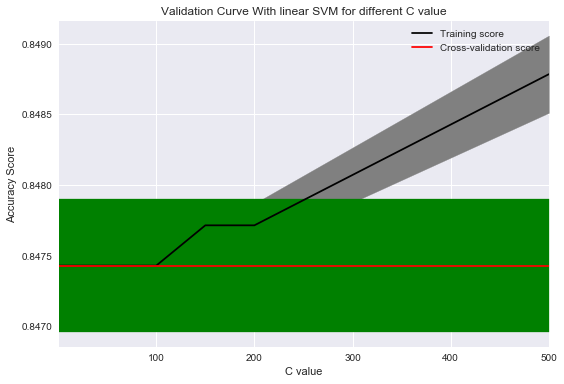

In [47]:
# Build model with linear kernel with random and grid search
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
from sklearn.model_selection import validation_curve
    
   
# Use grid search for L2
C=[.1,1,10,100]
kernel=['linear']
gamma=['auto']

tuned_parameters=dict(C=C, kernel=kernel,gamma=gamma)

#Using GridSearchCV
model = GridSearchCV(svm.SVC(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train, y_train)


print('Best parameters with linear karnel and grid search\n',model.best_estimator_)
#print('Model test score', model.score(X_test, y_test))

optimumc=model.best_estimator_.C
#optimumkernel=model.best_estimator_.kernel
optimumgamma=model.best_estimator_.gamma

#print(type(X_train),type(y_train))

#build model with best parameter
model = svm.SVC(C=optimumc,gamma=optimumgamma)
model.fit(X_train, y_train)

pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn) 
fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat);tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn) 
fscoretrain=2*precision*recall/(precision+recall)


aa=pd.DataFrame({'type':['Grid search BOW'],'kernel':['linear'],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest],\
                 'C':[model.C],'gamma':[model.gamma]})


# Check test accuracy
print("Test accuracy using linear kernel",model.score(X_test, y_test))
# Print coefficients
# check no of parameter
#w = model.coef_
#print('Count of non zero element in coefficient',np.count_nonzero(w))
#print('Model test score',model.score(X_test,y_test))
print(aa)
#Plot accuracy with C
#create plot for training and test validation
# Calculate accuracy on training and test set using range of parameter values
C=[1,10,50,100,150,200,500]
param_range=[1,10,50,100,150,200,500]
train_scores, test_scores = validation_curve(svm.SVC(), X_train, y_train, param_name="C",param_range=C,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With linear SVM for different C value")
plt.xlabel("C value")
plt.ylabel("Accuracy Score")
plt.xlim(1,500)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


In [48]:
# Try random search
from sklearn.model_selection import RandomizedSearchCV

C=[.1,.5,.8,1,2]
kernel=['linear']
gamma=['auto']

tuned_parameters=dict(C=C, kernel=kernel,gamma=gamma)

#Using random search
model = RandomizedSearchCV(svm.SVC(), tuned_parameters, random_state=1, scoring = 'f1', cv=5)

#print(model)

print('Best parameters using linear kernel and random search \n',model.estimator)
#build model with best parameter
optimumc=model.estimator.C
#optimumkernel=model.best_estimator_.kernel
optimumgamma=model.estimator.gamma


model = svm.SVC(C=optimumc,gamma=optimumgamma)
model.fit(X_train, y_train)

pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn) 
fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat);tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn) 
fscoretrain=2*precision*recall/(precision+recall)

bb=pd.DataFrame({'type':['Random Search BOW'],'kernel':['linear'],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest],\
                 'C':[model.C],'gamma':[model.gamma]})
aa=aa.append(bb)

print(aa)
# Check test accuracy
print("Test accuracy",model.score(X_test, y_test))



Best parameters using linear kernel and random search 
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicted     1   All
Actual               
0           534   534
1          2966  2966
All        3500  3500
     C  accuracy_test  accuracy_train  fscore_test  fscore_train gamma  \
0  1.0       0.833333        0.847429        0.625      0.628923  auto   
0  1.0       0.833333        0.847429        0.625      0.628923  auto   

   kernel               type  
0  linear    Grid search BOW  
0  linear  Random Search BOW  
Test accuracy 0.833333333333


# Apply RBF kernel

Best parameters with rbf karnel and grid search
 SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicted     1   All
Actual               
0           534   534
1          2966  2966
All        3500  3500
Test accuracy using linear kernel 0.833333333333
Best parameters using rbf kernel and random search 
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Test accuracy 0.833333333333


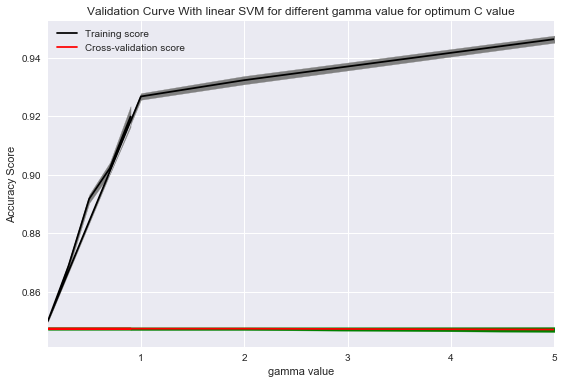

In [49]:
# Build model with linear kernel with random and grid search

import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
    
    
# Use grid search for L2
C=[.1,1,10,100]
kernel=['rbf']
gamma=[.01,.1,1,10]

tuned_parameters=dict(C=C, kernel=kernel,gamma=gamma)

#Using GridSearchCV
model = GridSearchCV(svm.SVC(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train, y_train)


print('Best parameters with rbf karnel and grid search\n',model.best_estimator_)
#print('Model test score', model.score(X_test, y_test))

optimumc=model.best_estimator_.C
#optimumkernel=model.best_estimator_.kernel
optimumgamma=model.best_estimator_.gamma

#print(type(X_train),type(y_train))

#build model with best parameter
model = svm.SVC(C=optimumc,gamma=optimumgamma)
model.fit(X_train, y_train)

pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn) 
fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat);tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn) 
fscoretrain=2*precision*recall/(precision+recall)


bb=pd.DataFrame({'type':['Grid search BOW'],'kernel':['rbf'],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest],\
                 'C':[model.C],'gamma':[model.gamma]})
aa=aa.append(bb)


# Check test accuracy
print("Test accuracy using linear kernel",model.score(X_test, y_test))
# Print coefficients
# check no of parameter
#w = model.coef_
#print('Count of non zero element in coefficient',np.count_nonzero(w))
#print('Model test score',model.score(X_test,y_test))


C=[.1,.5,.8,1,2,5]
kernel=['rbf']
gamma=[.01,.1,1,10]

tuned_parameters=dict(C=C, kernel=kernel,gamma=gamma)

#Using random search
model = RandomizedSearchCV(svm.SVC(), tuned_parameters, random_state=1, scoring = 'f1', cv=5)

#print(model)

print('Best parameters using rbf kernel and random search \n',model.estimator)
#build model with best parameter
optimumc=model.estimator.C
#optimumkernel=model.best_estimator_.kernel
optimumgamma=model.estimator.gamma


model = svm.SVC(C=optimumc,gamma=optimumgamma)
model.fit(X_train, y_train)

# Check test accuracy
print("Test accuracy",model.score(X_test, y_test))

# plot accuracy with gamma with optimum c
gamma=[.9,.7,.5,.3,.1,1,2,5]
param_range=[.9,.7,.5,.3,.1,1,2,5]
train_scores, test_scores = validation_curve(svm.SVC(kernel='rbf',C=optimumc), X_train, y_train, param_name="gamma", \
                                              param_range=gamma,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With linear SVM for different gamma value for optimum C value")
plt.xlabel("gamma value")
plt.ylabel("Accuracy Score")
plt.xlim(.1,5)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


# Try with TFIDF

In [50]:
tf_idf_vect = TfidfVectorizer()
final_counts = tf_idf_vect.fit_transform(clean_data['CleanedText'].values)

x=final_counts
y =clean_data['Score']

x = normalize(x, norm='l1', axis=0)

n=x.shape[0]
n1=int(n*.3)
#y should be changed to binary

encoded_column_vector = label_binarize(y, classes=['negative','positive']) # negative will be 0 and positive will be 1
encoded_labels = np.ravel(encoded_column_vector) # Reshape array
y=encoded_labels

y_test=y[0:n1]
y_train=y[n1:n+1]


X_test = x[0:n1,:]
X_train= x[n1:n+1,:]
y_test=y[0:n1]
y_train=y[n1:n+1]
print('size of X_train, X_test, y_train , y_test ',X_train.shape, X_test.shape,y_train.shape,y_test.shape)

# Build model with linear kernel with random and grid search
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
    
  
# Use grid search for L2
C=[.1,1,10,100]
kernel=['rbf']
gamma=[.01,.1,1,10]

tuned_parameters=dict(C=C, kernel=kernel,gamma=gamma)

#Using GridSearchCV
model = GridSearchCV(svm.SVC(), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train, y_train)


print('Best parameters with rbf karnel and grid search using TFIDF\n',model.best_estimator_)
#print('Model test score', model.score(X_test, y_test))

optimumc=model.best_estimator_.C
#optimumkernel=model.best_estimator_.kernel
optimumgamma=model.best_estimator_.gamma

#print(type(X_train),type(y_train))

#build model with best parameter
model = svm.SVC(C=optimumc,gamma=optimumgamma)
model.fit(X_train, y_train)

pred=model.predict(X_test)
mat=pd.crosstab(y_test, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
tp=mat.iloc[1,1] ;tn=mat.iloc[0,0] ;fp=mat.iloc[0,1];fn=mat.iloc[1,0];precision=tp/(tp+fp) 
recall=tp/(tp+fn) 
fscoretest=2*precision*recall/(precision+recall)

pred=model.predict(X_train)
mat=pd.crosstab(y_train, pred, rownames=['Actual'], colnames=['Predicted'], margins=True) 
print(mat);tp=mat.iloc[1,1] ;tn=mat.iloc[0,0];fp=mat.iloc[0,1] ;fn=mat.iloc[1,0] ;precision=tp/(tp+fp);
recall=tp/(tp+fn) 
fscoretrain=2*precision*recall/(precision+recall)


bb=pd.DataFrame({'type':['Grid search TFIDF'],'kernel':['rbf'],'accuracy_train':[model.score(X_train,y_train)], \
                 'fscore_train':[fscoretrain],'accuracy_test':[model.score(X_test,y_test)],'fscore_test':[fscoretest],\
                 'C':[model.C],'gamma':[model.gamma]})
aa=aa.append(bb)

# Check test accuracy
print("Test accuracy using linear kernel TFIDF",model.score(X_test, y_test))
# Print coefficients
# check no of parameter
#w = model.coef_
#print('Count of non zero element in coefficient',np.count_nonzero(w))
#print('Model test score',model.score(X_test,y_test))


C=[.1,.5,.8,1,2,5,10,100]
kernel=['rbf']
gamma=[.01,.1,1,10]

tuned_parameters=dict(C=C, kernel=kernel,gamma=gamma)

#Using random search
model = RandomizedSearchCV(svm.SVC(), tuned_parameters, random_state=1, scoring = 'f1', cv=5)

#print(model)

print('Best parameters using rbf kernel and random search TFIDF\n',model.estimator)
#build model with best parameter
optimumc=model.estimator.C
#optimumkernel=model.best_estimator_.kernel
optimumgamma=model.estimator.gamma


model = svm.SVC(C=optimumc,gamma=optimumgamma)
model.fit(X_train, y_train)

# Check test accuracy
print("Test accuracy",model.score(X_test, y_test))



size of X_train, X_test, y_train , y_test  (3500, 9911) (1500, 9911) (3500,) (1500,)
Best parameters with rbf karnel and grid search using TFIDF
 SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicted     1   All
Actual               
0           534   534
1          2966  2966
All        3500  3500
Test accuracy using linear kernel TFIDF 0.833333333333
Best parameters using rbf kernel and random search TFIDF
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Test accuracy 0.833333333333


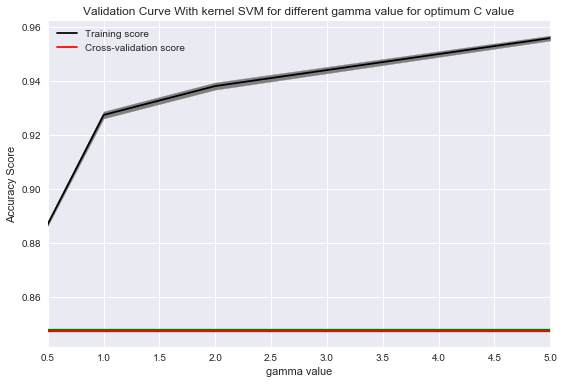

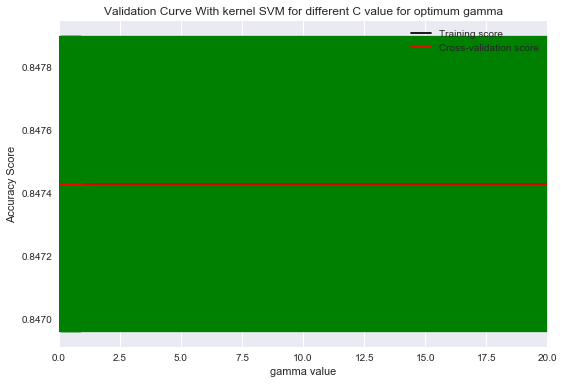

In [51]:
# Plot
# plot accuracy with gamma with optimum c
gamma=[.05,.03,.02,.01,1,2,5]
param_range=[.05,.03,.02,.01,1,2,5]
train_scores, test_scores = validation_curve(svm.SVC(kernel='rbf',C=optimumc), X_train, y_train, param_name="gamma", \
                                              param_range=gamma,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With kernel SVM for different gamma value for optimum C value")
plt.xlabel("gamma value")
plt.ylabel("Accuracy Score")
plt.xlim(.5,5)
plt.tight_layout()
plt.legend(loc="best")
plt.show()

# plot accuracy with C with optimum gamma
C=[.01,.9,.7,.5,.3,.1,1,2,5,10,20]
param_range=[.01,.9,.7,.5,.3,.1,1,2,5,10,20]
train_scores, test_scores = validation_curve(svm.SVC(kernel='rbf',gamma=optimumgamma), X_train, y_train, param_name="C", \
                                              param_range=C,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_scores_mean, label="Training score", color="black")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="red")
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="gray")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green")
plt.title("Validation Curve With kernel SVM for different C value for optimum gamma")
plt.xlabel("gamma value")
plt.ylabel("Accuracy Score")
plt.xlim(.01,20)
plt.tight_layout()
plt.legend(loc="best")
plt.show()


In [52]:
aa

,C,accuracy_test,accuracy_train,fscore_test,fscore_train,gamma,kernel,type
0,1.0,0.833333,0.847429,0.625,0.628923,auto,linear,Grid search BOW
0,1.0,0.833333,0.847429,0.625,0.628923,auto,linear,Random Search BOW
0,0.1,0.833333,0.847429,0.625,0.628923,0.01,rbf,Grid search BOW
0,0.1,0.833333,0.847429,0.625,0.628923,0.01,rbf,Grid search TFIDF


# Conclusion

The scores are below


In [53]:

aa

,C,accuracy_test,accuracy_train,fscore_test,fscore_train,gamma,kernel,type
0,1.0,0.833333,0.847429,0.625,0.628923,auto,linear,Grid search BOW
0,1.0,0.833333,0.847429,0.625,0.628923,auto,linear,Random Search BOW
0,0.1,0.833333,0.847429,0.625,0.628923,0.01,rbf,Grid search BOW
0,0.1,0.833333,0.847429,0.625,0.628923,0.01,rbf,Grid search TFIDF
